# Principal Component Analysis (PCA)

主成分分析（principal component analysis, PCA）是一种常用的无监督学习方法，这一方法利用正交变换把由线性相关变量表示的观测数据转换为少数几个由线性无关变量表示的数据，线性无关的变量称为主成分。主成分的个数通常小于原始变量的个数，所以主成分分析属于降维方法。

这里直接拿我在Coursera上学的这门课程：https://www.coursera.org/learn/pca-machine-learning/home/welcome 的作业，实现PCA。就不重复造轮子了。

In [0]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

Now, let's plot a digit from the dataset:

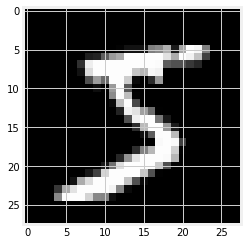

In [31]:
from ipywidgets import interact
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
%matplotlib inline

plt.figure(figsize=(4,4))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

## 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $\boldsymbol S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $M$ eigenvectors.

In [0]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0)  
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = (X - mu) / std_filled        
    
    return Xbar, mu, std_filled


In [0]:
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs SHOULD BE sorted in descending
        order of the eigen values
        
        Hint: take a look at np.argsort for how to sort in numpy.
    """
    eVals, eVecs = np.linalg.eig(S)
    order = np.absolute(eVals).argsort()[::-1]
    eVals = eVals[order]
    eVecs = eVecs[:,order]  
    
    return (eVals, eVecs)  

In [0]:
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    P = B @ np.linalg.inv(B.T @ B) @ B.T 
    
    return P

Now, with the help of the functions you have implemented above, let's implement PCA! __When you implement `PCA`, do take advantage of the functions that you have implemented above.__

In [0]:
def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of size (N, D) the reconstruction
        of X from the first `num_components` principal components.
    """
    # Compute the data covariance matrix S
    S = np.cov(X, rowvar=False, bias=True)

    # Next find eigenvalues and corresponding eigenvectors for S by implementing eig().
    eig_vals, eig_vecs = eig(S)
    
    # Reconstruct the images from the lowerdimensional representation
    # To do this, we first need to find the projection_matrix (which you implemented earlier)
    # which projects our input data onto the vector space spanned by the eigenvectors
    P = projection_matrix(eig_vecs[:,:num_components]) # projection matrix
    
    # Then for each data point x_i in the dataset X 
    #   we can project the original x_i onto the eigenbasis.
    X_reconstruct = (P @ X.T).T
    
    return X_reconstruct
    

In [0]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (X.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



In [0]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

In [0]:
loss = []
reconstructions = []
for num_component in range(1, 200):
    reconst = PCA(Xbar, num_component)
    reconst = np.real(reconst)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [53]:
loss

array([[  1.        , 569.447737  ],
       [  2.        , 536.05960789],
       [  3.        , 508.2502863 ],
       [  4.        , 487.01890731],
       [  5.        , 467.5716098 ],
       [  6.        , 451.17808689],
       [  7.        , 436.5384839 ],
       [  8.        , 422.99202081],
       [  9.        , 411.01404666],
       [ 10.        , 399.58408482],
       [ 11.        , 389.58456758],
       [ 12.        , 379.83978394],
       [ 13.        , 371.02934216],
       [ 14.        , 362.36689903],
       [ 15.        , 353.93855686],
       [ 16.        , 345.92550672],
       [ 17.        , 338.17547788],
       [ 18.        , 330.70873035],
       [ 19.        , 323.73303138],
       [ 20.        , 316.93886523],
       [ 21.        , 310.49698327],
       [ 22.        , 304.20199181],
       [ 23.        , 298.17260088],
       [ 24.        , 292.31351166],
       [ 25.        , 286.60598589],
       [ 26.        , 281.24976283],
       [ 27.        , 276.07351199],
 

We can also put these numbers into perspective by plotting them.

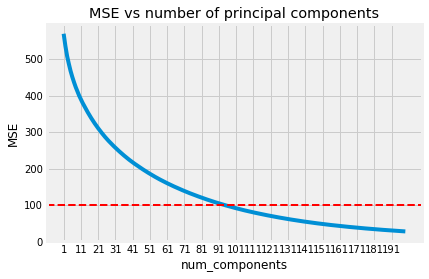

In [58]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 200, 10));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers don't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the original eight as the leftmost image. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [41]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy.

In [42]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…

## 2. PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of data points we
have. Then it might be inefficient to perform PCA with the implementation above. Instead,
as mentioned in the lectures, we can implement PCA in a more efficient manner, which we
call PCA for high-dimensional data (PCA_high_dim).

Consider the __normalized__ data matrix $\boldsymbol{\bar{X}}$ of size $N \times D$ where $D > N$. To do PCA we perform the following steps:

* We solve the following eigenvalue/eigenvector equation for the matrix $\frac{1}{N} \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T$, i.e. we solve for $\lambda_i$, $\boldsymbol c_i$ in
$$\frac{1}{N} \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T \boldsymbol c_i = \lambda_i \boldsymbol c_i.$$

* We want to recover original eigenvectors $\boldsymbol b_i$ of the data covariance matrix $\boldsymbol S = \frac{1}{N} \boldsymbol{\bar{X}^T} \boldsymbol{\bar{X}}$.

* Left-multiply the eigenvectors $\boldsymbol c_i$ by $\boldsymbol{\bar{X}}^T$ yields
$$\frac{1}{N} \boldsymbol{\bar{X}}^T \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T \boldsymbol c_i = \lambda_i \boldsymbol{\bar{X}}^T \boldsymbol c_i$$ and we recover $\boldsymbol b_i=\boldsymbol{\bar{X}}^T \boldsymbol c_i$ as eigenvector of $\boldsymbol S$ with the eigenvalue $\lambda_i$.

In [0]:
def PCA_high_dim(X, num_components):
    """Compute PCA for small sample size. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of data points in the training set. You may assume the input 
           has been normalized.
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` principal components.
    """
    N, D = X.shape
    M = (1/N)*(X @ X.T) # EDIT THIS, compute the matrix \frac{1}{N}XX^T.
    eig_vals, eig_vecs = eig(M) # EDIT THIS, compute the eigenvalues. 
    U = X.T @ eig_vecs # EDIT THIS. Compute the eigenvectors for the original PCA problem.
    # Similar to what you would do in PCA, compute the projection matrix,
    # then perform the projection.
    P = projection_matrix(U[:, 0:num_components]) # projection matrix
    X_reconstruct = (P @ X.T).T  
    
    return X_reconstruct

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA` correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`.

We can use this __invariant__
to test our implementation of `PCA_high_dim`, assuming that we have correctly implemented `PCA`.

In [44]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))
# In fact, you can generate random input dataset to verify your implementation.
print('correct')

correct


Now let's compare the running time between `PCA` and `PCA_high_dim`.

__Tips__ for running benchmarks or computationally expensive code:

When you have some computation that takes up a non-negligible amount of time. Try separating
the code that produces output from the code that analyzes the result (e.g. plot the results, comput statistics of the results). In this way, you don't have to recompute when you want to produce more analysis.

In [0]:
def time(f, repeat=10):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [0]:
times_mm0 = []
times_mm1 = []

for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize]
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

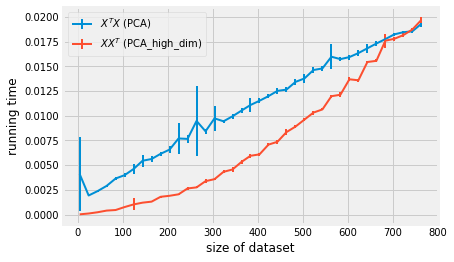

In [47]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

We first benchmark the time taken to compute $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$. Jupyter's magic command `%time` is quite handy.

Next we benchmark `PCA`, `PCA_high_dim`.

In [0]:
times0 = []
times1 = []

for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA( XX, 2))
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, 2))
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

Alternatively, use the `time` magic command.

In [49]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here, so that our output does not show the result of computing `Xbar @ Xbar.T`

CPU times: user 47.4 ms, sys: 6.88 ms, total: 54.3 ms
Wall time: 27.8 ms
CPU times: user 60.1 ms, sys: 8.02 ms, total: 68.1 ms
Wall time: 34.3 ms


We can also compare the running time for __PCA__ and __PCA\_high\_dim__ directly. Spend some time and think about what this plot means. We mentioned in lectures that `PCA_high_dim` are advantageous when
we have dataset size $N$ < data dimension $D$. Although our plot for the two running times does not intersect exactly at $N = D$, it does show the trend.

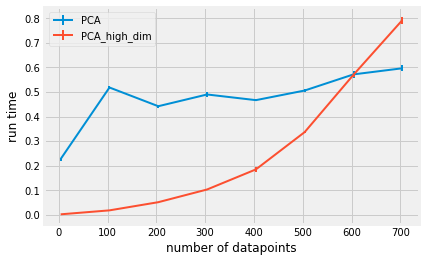

In [50]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

Again, with the magic command `time`.

In [51]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

CPU times: user 1.08 s, sys: 267 ms, total: 1.34 s
Wall time: 695 ms
CPU times: user 2.68 s, sys: 657 ms, total: 3.33 s
Wall time: 1.69 s
